# Convolutions and Correlations

In this notebook, we interact with __correlations__, which are a version of a __convolution__ defined by:
\begin{equation}
\left[f\star g\right](\tau) = \int_{-\infty}^\infty{f(g)~g^*(t-\tau)~dt},
\end{equation}
where $^*$ denotes the complex conjugate. For convolution, we omit the conjugate, using $g(\tau - t)$ in place of $g^*(t-\tau)$.

## Simulation 1: Interacting with the Convolution


In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, FloatSlider, Layout

<IPython.core.display.Javascript object>


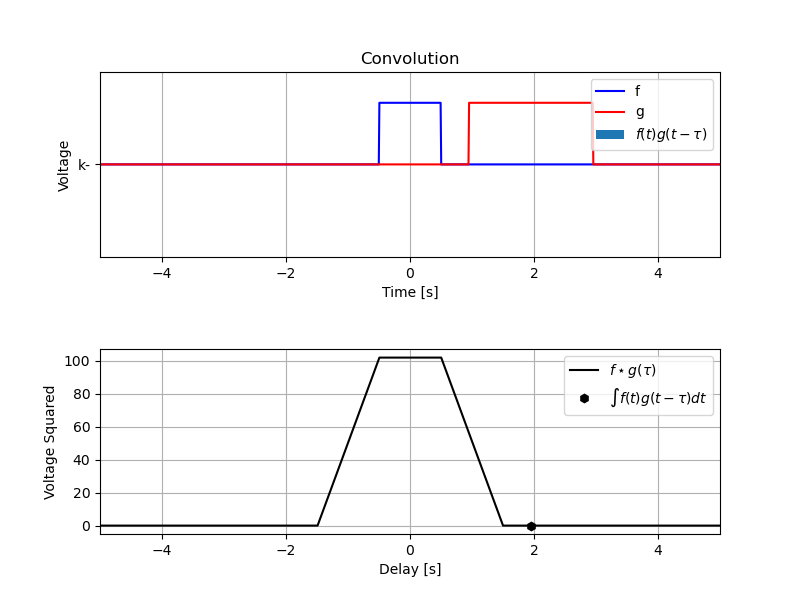

interactive(children=(FloatSlider(value=0.0, description='Offset', layout=Layout(grid_area='footer', width='au…

In [3]:
# SIMULATION PARAMETERS
TMIN = -5
TMAX = 5

def f(t):
    '''The first function to convolve.'''
    #freq = 0.1
    #return np.sin(2*np.pi * freq * t)
    return np.where(np.abs(t) < 0.5, 1, 0)

def g(t):
    '''The second function to convolve.'''
    return np.where(np.abs(t) < 1, 1, 0)

offset_initial = 0.
ts = np.linspace(TMIN, TMAX, 1024)

fig, (ax1,ax2) = plt.subplots(2, figsize=(8,6))
fig.subplots_adjust(hspace=0.5)
f_line, = ax1.plot(ts, f(ts), 'b-', label='f')
g_line, = ax1.plot(ts, g(ts - offset_initial), 'r-', label='g')
fg_coll = ax1.fill_between(ts, f(ts) * g(ts - offset_initial), 'k-', label='$f(t) g(t-\\tau)$')
fCg_line, = ax2.plot(ts, np.convolve(f(ts), g(ts), mode='same'), 'k-', label='$f\\star g(\\tau)$')
fg_pnt, = ax2.plot([offset_initial], np.sum(f(ts) * g(ts - offset_initial)), 'kh',
                   label='$\\int{f(t) g(t-\\tau) dt}$')

# Slider controlling offset
off_widget = FloatSlider(offset_initial, min=ts.min(), max=ts.max(), step=0.01, 
                         description='Offset',
                         style={'description_width':'initial'},
                         layout=Layout(width='auto', grid_area='footer'))

def update(offset):
    '''Update plots for each line according to the time step. Reads dt 
    from dt_widget.'''
    g_line.set_ydata(g(ts-offset))
    fg_pnt.set_xdata([offset])
    fg_pnt.set_ydata(np.sum(f(ts) * g(ts-offset)))
    path = fg_coll.get_paths()[0]
    path.vertices[:ts.size,1] = f(ts) * g(ts-offset)
    
def init(ax1, ax2):
    '''Set initial plot parameters.'''
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Voltage')
    ax2.set_xlabel('Delay [s]')
    ax2.set_ylabel('Voltage Squared')
    ax1.set_xlim(TMIN, TMAX)
    ax2.set_xlim(TMIN, TMAX)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_title('Convolution')
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    ax1.grid(True)
    ax2.grid(True)
    
init(ax1, ax2)
interact(update, offset=off_widget)
plt.show()

# Simulation 2: Convolution Theorem

In class, we learned about the __Convolution Theorem__ relating the convolution (an operation on two functions) to the __Fourier Transform__.

The Fourier transform definition we use is
\begin{equation}
\tilde f(\omega) = \int_{-\infty}^\infty{f(t)~e^{-i\omega t}~dt}
\end{equation}
with corresponding inverse\
\begin{equation}
f(t) = \frac{1}{2\pi}\int_{-\infty}^\infty{\tilde f(\omega)~e^{i\omega t}~d\omega}.
\end{equation}

The convolution theorem states that the convolution operation in time domain is equivalent to taking the product of the functions in frequency domain. For correlation, this looks like:
\begin{equation}
\widetilde{\left[f\star g\right](\tau)} = \tilde f(\omega)\cdot \tilde g^*(\omega)
\end{equation}

We can try to test this numerically using the {\tt numpy.fft.fft} and {\tt numpy.convolve} functions. In this comparison, we will see that, while the two supposedly equivalent ways of convolving functions look similar, there are critical differences that depend on how one treats the __boundary conditions__ of a numerical integral that does not reach to infinity.

<IPython.core.display.Javascript object>


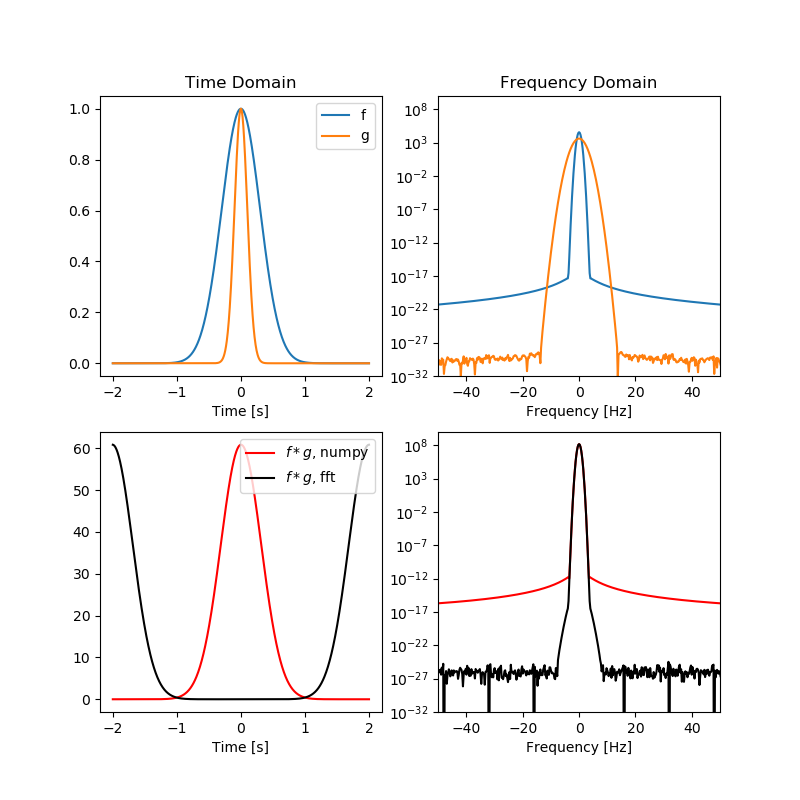

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [3]:
# SIMULATION PARAMETERS
ts = np.linspace(-2, 2, 1024)
fqs = np.fft.fftfreq(ts.size, np.median(np.diff(ts)))

def gaussian(t, sigma):
    return np.exp(-t**2 / (2*sigma**2))

f = gaussian(ts, 0.3)
g = gaussian(ts, 0.1)

fg1 = np.convolve(f, g, mode='same')
fg2 = np.fft.ifft(np.fft.fft(f) * np.fft.fft(g))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
line1, = ax1.plot(ts, f, label='f')
line2, = ax1.plot(ts, g, label='g')
ax1.legend(loc='upper right')
ax1.set_xlabel('Time [s]')
ax1.set_title('Time Domain')
line3, = ax3.plot(ts, fg1, 'r', label='$f*g$, numpy')
line4, = ax3.plot(ts, fg2, 'k', label='$f*g$, fft')
ax3.legend(loc='upper right')
ax3.set_xlabel('Time [s]')

ax2.semilogy(np.fft.fftshift(fqs), np.fft.fftshift(np.abs(np.fft.fft(f))**2), color=line1.get_color())
ax2.semilogy(np.fft.fftshift(fqs), np.fft.fftshift(np.abs(np.fft.fft(g))**2), color=line2.get_color())
ax2.set_ylim(1e-32, 1e10)
ax2.set_xlim(-50, 50)
ax2.set_xlabel('Frequency [Hz]')
ax2.set_title('Frequency Domain')
ax4.semilogy(np.fft.fftshift(fqs), np.fft.fftshift(np.abs(np.fft.fft(fg1))**2), color=line3.get_color())
ax4.semilogy(np.fft.fftshift(fqs), np.fft.fftshift(np.abs(np.fft.fft(fg2))**2), color=line4.get_color())
ax4.set_ylim(1e-32, 1e10)
ax4.set_xlim(-50, 50)
ax4.set_xlabel('Frequency [Hz]')

plt.show()

As you can see above, the red curve ({\tt numpy.convolve}) produces a significantly different result from our homegrown ${\tt fft}$ method of computing the convolution. The biggest discrepancy, the fact that the peaks are discrepant, is explainable by where the {\tt fft} function puts the zero-point of an array. In the next plot, we shift it over using {\tt fftshift}. However, we shall see that this is not the only difference between the two curves.

<IPython.core.display.Javascript object>


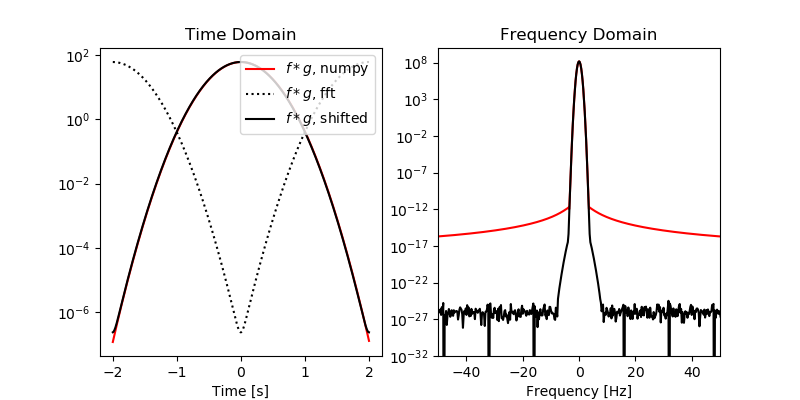

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Frequency Domain')

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))
ax1.legend(loc='upper right')
ax1.set_xlabel('Time [s]')
line1, = ax1.semilogy(ts, fg1, 'r', label='$f*g$, numpy')
ax1.semilogy(ts, fg2, 'k:', label='$f*g$, fft')
line2, = ax1.semilogy(ts, np.fft.fftshift(fg2), 'k', label='$f*g$, shifted')
ax1.legend(loc='upper right')
ax1.set_xlabel('Time [s]')
ax1.set_title('Time Domain')

ax2.semilogy(np.fft.fftshift(fqs), np.fft.fftshift(np.abs(np.fft.fft(fg1))**2), color=line1.get_color())
ax2.semilogy(np.fft.fftshift(fqs), np.fft.fftshift(np.abs(np.fft.fft(fg2))**2), color=line2.get_color())
ax2.set_ylim(1e-32, 1e10)
ax2.set_xlim(-50, 50)
ax2.set_xlabel('Frequency [Hz]')
ax2.set_title('Frequency Domain')

In this final plot, we have shifted the {\tt fft} output to match the zero point of the {\tt numpy.convolve} output, but shifting to a logarithmic vertical axis, we see that there are numerical differences in the time-domain waveform that correspond to significant "wings" in the correlation spectra on the right. In particular, the black curve ({\tt fft}) bends up slightly at the edges of the time plot. This is because the {\tt fft} library assumes finite arrays have periodic boundary conditions (which is the only analytic assumption that makes sense). As a result, the {\tt fft} has to bend up slightly to smoothly connect the edges of our time window.

Which is correct? The answer depends on how you define correct. The {\tt fft} version outputs a spectrum that avoids spurious wings. The {\tt numpy.convolve} version avoids the assumption of a periodic boundary condition. These two answers both have their uses, but you can't have it both ways: the wings *are* the discontinuity that happens at the edge of the array.